In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import keras
from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
from kaggle_util import *
from models import *

t_start = time.time()

Using TensorFlow backend.


In [2]:
img_size_ori = 101
img_size_target = 101

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [3]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

train_df["images"] = [np.array(load_img("../input/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm(train_df.index)]
train_df["masks"] = [np.array(load_img("../input/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm(train_df.index)]
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)
train_df['hassalt'] = train_df['masks'].apply(lambda x: (x.max()!=0) * 1)

  0%|          | 0/4000 [00:00<?, ?it/s]/home/kownse/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:487: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
100%|██████████| 4000/4000 [00:01<00:00, 2176.08it/s]


In [4]:
def get_splits(train_df, train_idx, val_idx):
    X_train = train_df.iloc[train_idx]
    X_valid = train_df.iloc[val_idx]
    x_train = np.array(X_train.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    x_valid = np.array(X_valid.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    msk_train = np.array(X_train.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    msk_val = np.array(X_valid.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_train = X_train.hassalt.values
    y_valid = X_valid.hassalt.values
    id_train = X_train.index.values
    id_valid = X_valid.index.values
    return x_train, x_valid, msk_train, msk_val, y_train, y_valid, id_train, id_valid

In [5]:
pred_vals = []
msk_vals = []
pred_tests = []
x_test = np.array([(np.array(load_img("../input/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['hassalt'])):
    print('predict for fold', fold)
    
    start_feature = 32
    batch_size = 32
    dropout = 0.5
    base_name = 'Unet_resnet_deeper_fix5_{}_{}_{}_{}'.format(start_feature, batch_size, dropout, fold)
    basic_name = '../model/segmenter/{}'.format(base_name)
    save_model_name = basic_name + '.model'

    model = load_model(save_model_name,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})
    
    x_train, x_valid, msk_train, msk_val, y_train, y_valid, id_train, id_valid = get_splits(train_df, train_idx, 
                                                                                            val_idx)
    
    preds_valid = predict_result(model,x_valid,img_size_target)
    pred_vals.append(preds_valid)
    msk_vals.append(msk_val)
    
    preds_test = predict_result(model,x_test,img_size_target)
    pred_tests.append(preds_test)

    from keras import backend as K
    K.clear_session()
    
    

/home/kownse/.local/lib/python3.6/site-packages/keras_preprocessing/image.py:487: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



predict for fold 0
18000/18000 [==============================] - 63s 3ms/step
predict for fold 1
18000/18000 [==============================] - 62s 3ms/step
predict for fold 2
18000/18000 [==============================] - 62s 3ms/step
predict for fold 3
18000/18000 [==============================] - 62s 3ms/step
predict for fold 4
18000/18000 [==============================] - 63s 3ms/step


In [6]:
val_ids = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['hassalt'])):
    val_ids += list(train_df.iloc[val_idx].index.values)

In [7]:
pred_all = np.concatenate(pred_vals, axis=0)
msk_all = np.concatenate(msk_vals, axis= 0)


[0.887575 0.8882   0.888625 0.889075 0.88935  0.8896   0.8903   0.89095
 0.89115  0.891275 0.891675 0.89185  0.892375 0.892575 0.89285  0.8936
 0.89425  0.895825 0.895825 0.89605  0.89545  0.8952   0.89525  0.894825
 0.894025 0.893825 0.893175 0.892825 0.89225  0.8919   0.891475 0.891275
 0.890575 0.890075 0.889625]


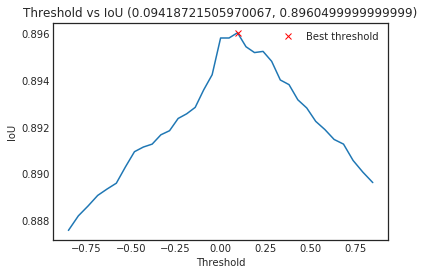

In [8]:

thresholds_ori = np.linspace(0.3, 0.7, 35)
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(msk_all, pred_all > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()



In [9]:
val_all = (pred_all > threshold_best) * 1
df_iou = pd.DataFrame(columns=['id', 'iou'])
cnt = 0
for i in tqdm_notebook(range(len(val_all))):
    id = val_ids[i]
    iou = iou_metric_batch(msk_all[i], val_all[i])
    df_iou = df_iou.append({'id':id, 'iou':iou}, ignore_index=True)
# for i in range(len(val_all)):
#     if iou_metric_batch(msk_all[i], val_all[i]) < 0.5:
        
#         fig, axis = plt.subplots(1, 3)
#         img = cv2.imread('../input/train/images/{}.png'.format(val_ids[i]))
#         axis[0].imshow(img)
#         axis[1].imshow(msk_all[i].squeeze())
#         axis[2].imshow(val_all[i].squeeze())
#         cnt += 1
#         if cnt > 20:
#             break
df_iou.to_csv('../result/iou_2.csv', index = False)

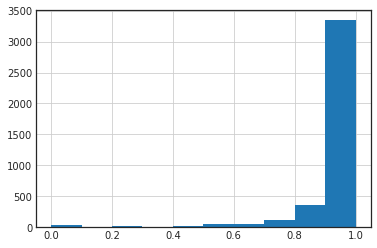

In [10]:
df_iou.iou.hist()

In [11]:
pred_tests_act = pred_tests
pred_test_all = np.zeros_like(pred_tests_act[0], dtype=np.float32)
for pre in pred_tests_act:
    pred_test_all += pre / len(pred_tests_act)

In [12]:
pred_dict = {idx: rle_encode(np.round(downsample(pred_test_all[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub = sub.reset_index()
save_result(sub, '../result/segmenter/unet_resnet_fix4_avg.csv', 
                        competition = 'tgs-salt-identification-challenge', 
                        send = True, index = False)


save result
upload result
cmd: kaggle competitions submit -c tgs-salt-identification-challenge -f ../result/segmenter/unet_resnet_fix4_avg.csv.7z -m "submit"
